# Armadillo real world example - Bayesian fit

In progress

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from pysip.params.prior import Gamma, LogNormal
from pysip.regressors import Regressor
from pysip.statespace import TwTi_RoRi

In [3]:
# Load and prepare the data
df = pd.read_csv("../../../../data/armadillo/armadillo_data_H2.csv").set_index("Time")
df.drop(df.index[-1], axis=0, inplace=True)
inputs = ["T_ext", "P_hea"]
outputs = ["T_int"]
y0 = df[outputs].iloc[0].values
sT = 3600.0 * 24.0
df.index /= sT

In [4]:
# Parameter settings for second order dynamic thermal model
parameters = [
    dict(name="Ro", scale=1e-2, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="Ri", scale=1e-3, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="Cw", scale=1e7 / sT, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="Ci", scale=1e6 / sT, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="sigw_w", scale=1e-2 * sT**0.5, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="sigw_i", value=0, transform="fixed"),
    dict(name="sigv", scale=1e-2, bounds=(0, None), prior=Gamma(2, 0.1)),
    dict(name="x0_w", loc=25, scale=7, prior=LogNormal(0, 1)),
    dict(name="x0_i", value=y0, transform="fixed"),
    dict(name="sigx0_w", value=0.1, transform="fixed"),
    dict(name="sigx0_i", value=0.1, transform="fixed"),
]

In [5]:
# Instantiate the model and use the first order hold approximation
model = TwTi_RoRi(parameters, hold_order=1)
reg = Regressor(model, outputs=outputs, inputs=inputs)

In [6]:
# Dynamic Hamiltonian Monte Carlo with multinomial sampling
# using way too few samples to get a good fit, for illustration purposes only
trace = reg.sample(df=df, tune=100, draws=100)

Only 100 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ro, Ri, Cw, Ci, sigw_w, sigv, x0_w]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 254 seconds.
/home/nicolas/.cache/pypoetry/virtualenvs/pysip-QZQT68sk-py3.11/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 72 divergences after t

In [7]:
# Compute the prior  and posterior predictive distribution
ds_prio = reg.prior_predictive(df=df, samples=100)
ds_post = reg.posterior_predictive(df=df)

Sampling: [Ci, Cw, Ri, Ro, sigv, sigw_w, x0_w]


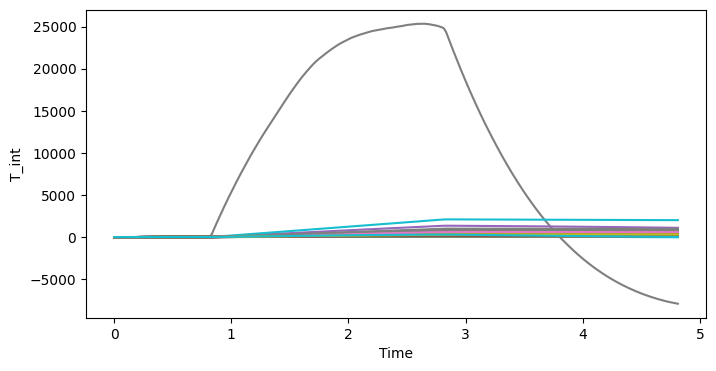

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
lines = ds_prio.T_int.plot(x="Time", hue="draw", add_legend=False, ax=ax)

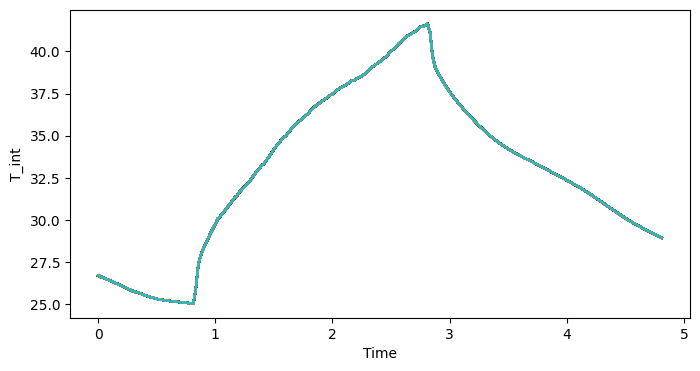

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
lines = ds_post.stack(samples=["chain", "draw"]).T_int.plot(
    x="Time", hue="chain", add_legend=False, ax=ax
)